Our preliminary strategy is to use what Dr. Shaffer referred to as a "14-foot random walk". The code below places a tree on some point of a circle with radius 14, with the previous tree acting as the center.

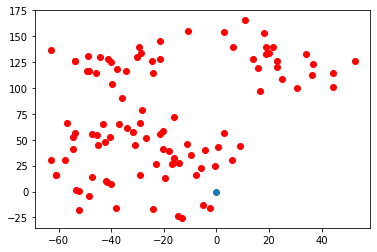

In [1]:
from pylab import *
import random
import math 

origin = [0,0]
scatter(origin[0], origin[1])

# radius of the circle
circle_r = 14
# center of the circle (x, y)
circle_x = 0
circle_y = 0


xL = [0]
yL = [0]

for i in range(100):
    # random angle
    alpha = 2 * math.pi * random.random()
    r = 14
    # calculating coordinates
    x = r * math.cos(alpha) + circle_x
    y = r * math.sin(alpha) + circle_y
    
    while (x in xL) or (y in yL):
        # random angle
        alpha = 2 * math.pi * random.random()
        r = 14
        # calculating coordinates
        x = r * math.cos(alpha) + circle_x
        y = r * math.sin(alpha) + circle_y
    
    xL.append(x)
    yL.append(y)
    circle_x = x
    circle_y = y

    scatter(x,y, c='r')

Clearly, this is not how we want our trees to be laid out. Many trees end up much too close together.

The following GIS analysis employs `geopandas`. Consult this link if you have installation troubles: https://stackoverflow.com/questions/54734667/error-installing-geopandas-a-gdal-api-version-must-be-specified-in-anaconda

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import numpy as np
import geopandas as gpd
shoreline = gpd.read_file("./data/louisiana_coast/louisiana_coastline.shp")

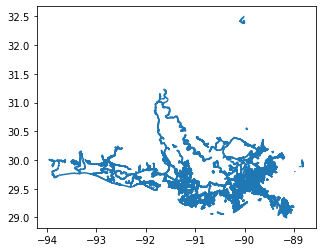

In [3]:
shoreline.plot(figsize=(5,5))

As we can see, the shores of Louisiana are very gnarled and complex. We can develop a few prospective placement algorithms using simpler plots of land. Take a rectangular plot that is only a few hundred feet long.

(-10.0, 110.0)

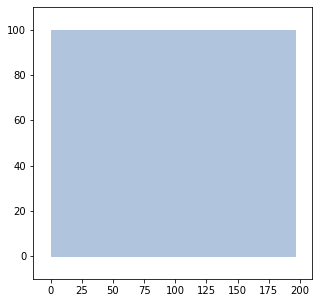

In [4]:
fig, ax = plt.subplots(1,figsize=(5,5))

rect = mpatches.Rectangle([0,0], width=196, height=100, color = 'lightsteelblue')
ax.add_patch(rect)

ax.set_xlim(-14,210)
ax.set_ylim(-10,110)

Our approach will eventually employ a greedy algorithm - we will first identify every viable location for a tree, then select the optimal ones retroactively. First, let's experiment with a few tree placement approaches. Continuing with our theme of 14-foot spacing, we can first fence the coastline with trees every 14 feet. 

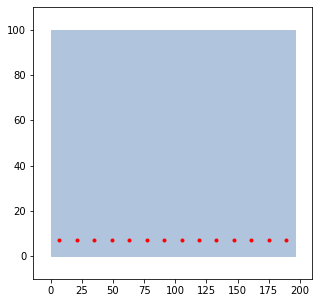

In [5]:
# To give the trees a little buffer, we can start a bit inland
x = 7
y = 7
tree_coords = [] # to aggregate the locations of existing trees
for i in range(196//14):
    ax.plot(x,y, 'ro', markersize='3')
    tree_coords.append((x,y))
    x += 14
ax.figure

The most intuitive approach would then be to place trees between these gaps 14 feet back, in a lattice of sorts.

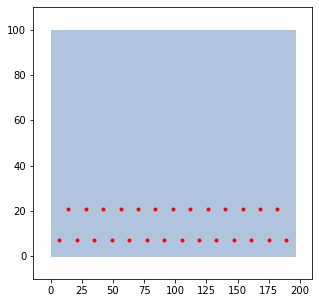

In [6]:
# Since we are branching off of the most recent row in this algorithm, it makes sense to store a copy separately.
last_row = []

long_row = tree_coords.copy()

# Sliding window approach: take the midpoint of tree i and tree i+1
for i in range(len(tree_coords)-1):
    x = (tree_coords[i][0] + tree_coords[i+1][0]) / 2
    y = 21
    ax.plot(x,y, 'ro', markersize='3')
    tree_coords.append((x,y))
    last_row.append((x,y))
ax.figure

In [7]:
short_row = last_row.copy()

We can extrapolate this approach across whatever coastal width we like. The only caveat is to compute midpoints using only the last row of trees.

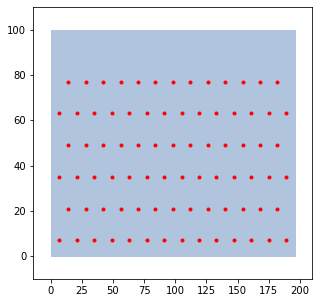

In [8]:
for i in range(1,5):
    y += 14
    # alternate placement of short and long rows
    if i%2 == 0:
        for point in short_row:
            x = point[0]
            ax.plot(x,y, 'ro', markersize='3')
            tree_coords.append((x,y))
            last_row.append((x,y))
            last_row = last_row[1:]

    else:
        for point in long_row:
            x = point[0]
            ax.plot(x,y, 'ro', markersize='3')
            tree_coords.append((x,y))
            last_row.append((x,y))
            last_row = last_row[1:]
            
ax.figure

Another potential approach is diagonal rows. We can try applying this to a differently shaped plot, as well.

(-5.0, 100.0)

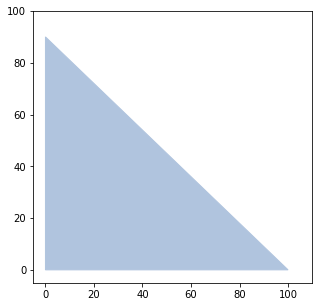

In [9]:
fig2, ax2 = plt.subplots(1,figsize=(5,5))

x = [0, 0, 100]
y = [0, 90, 0]

pts = [[0,0],[0,90],[100,0]]

tri = plt.Polygon(pts, color="lightsteelblue")
plt.gca().add_patch(tri)

ax2.set_xlim(-5,110)
ax2.set_ylim(-5,100)


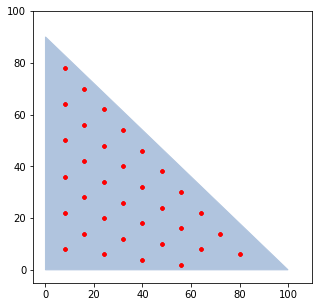

In [52]:
tree_coords = []

y = np.arange(2, 100, 14)
x = [0] * len(y)


for i in range(len(x)):
    tree_coords.append((x[i],y[i]))
    

for point in tree_coords:
    x0 = point[0]
    y0 = point[1]
    
    y0 -= 8
    x0 += 8
    
    while x0 <  196 and y0 > 0:
        ax2.plot(x0,y0, 'ro', markersize=3)
        y0 -= 8
        x0 += 8

ax2.figure

Lastly, we can try some random-walk "alleys" - partition the land into strips, then plant a random walk of trees across them.

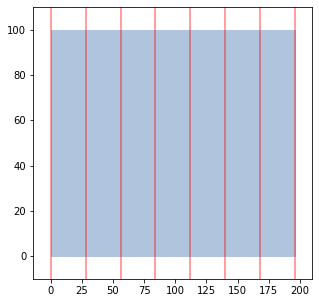

In [53]:
fig3, ax3 = plt.subplots(1,figsize=(5,5))

rect = mpatches.Rectangle([0,0], width=196, height=100, color = 'lightsteelblue')
ax3.add_patch(rect)

ax3.set_xlim(-14,210)
ax3.set_ylim(-10,110)

b_vals = []
line_refs = [] #to remove our alley-lines, purely visual
for x in np.arange(0,224, 28):
    b_vals.append(x)
    line_refs.append(plt.axvline(x, c='r', alpha = 0.5))

We can start each walk at the midpoint of each alley.

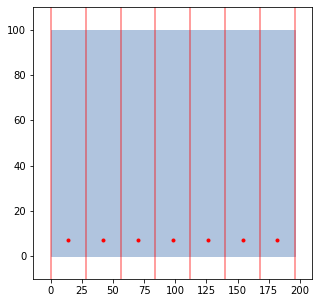

In [54]:
midpts = []
for i in range(len(b_vals)-1):
    x = (b_vals[i] + b_vals[i+1])/ 2
    ax3.plot(x, 7, 'ro', markersize=3)
    midpts.append((x, 7))
ax3.figure


We then establish an angle parameter for our random walk. We must also make sure that the rows do not walk into other lanes!

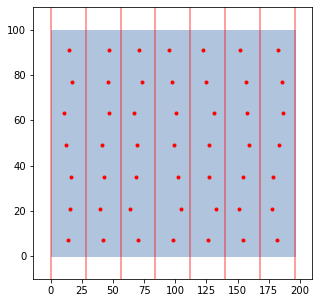

In [55]:
max_angle = (2 * math.pi)/3
min_angle = math.pi/3
r = 14
for point in midpts:
    alpha = (random.uniform(min_angle, max_angle))
    # calculating coordinates
    x0 = r * math.cos(alpha) + point[0] 
    y0 = r + point[1]
    ax3.plot(x0,y0, 'ro', markersize=3)
    for i in range(5):
        alpha = (random.uniform(min_angle, max_angle))        
        x_temp = r * math.cos(alpha) + x0 
        y0 = r + y0
        # to guard against lane spillage - if the tree gets too close to a boundary, reroll the angle.
        while x_temp <= (point[0]-5) or x_temp >= (point[0]+5):
            alpha = (random.uniform(min_angle, max_angle))
            x_temp = r * math.cos(alpha) + x0
        x0 = x_temp
        ax3.plot(x0,y0,'ro',markersize=3)
ax3.figure

We can remove our lane boundaries to get a better picture of our random walks.

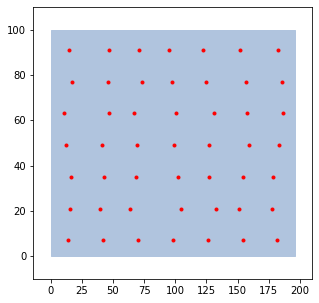

In [57]:
for line in line_refs:
    line.remove()
ax3.figure

This is a snippet I may use later!

In [35]:
# for j in range(5):
#     y += 14
#     if len(last_row) == 14:
#         for i in range(len(last_row)-1):
#             x = (last_row[0][0] + last_row[1][0]) / 2
#             y = y
#             ax.plot(x,y, 'ro', markersize='3')
#             tree_coords.append((x,y))
#             last_row.append((x,y))
#             last_row = last_row[1:]
#     elif len(last_row) == 13:
#         # add edge points
#         ax.plot(7, y, 'ro', markersize='3')
#         ax.plot(189, y, 'ro', markersize='3')
#         last_row.append((7,y))
#         for i in range(len(last_row)-1):
#             x = (last_row[0][0] + last_row[1][0]) / 2
#             y = y
#             ax.plot(x,y, 'ro', markersize='3')
#             tree_coords.append((x,y))
#             last_row.append((x,y))
#             last_row = last_row[1:]
#         last_row.append((189,y))   